# **Segmentación automática de la aorta**

In [ ]:
import os
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator 
from tensorflow import keras

In [ ]:
from keras.models import Model, Sequential
from keras.layers import Activation, Dense, BatchNormalization, Dropout, Conv2D, Conv2DTranspose, MaxPooling2D, UpSampling2D, Input, Reshape
from keras.callbacks import EarlyStopping
from keras import backend as K
from keras.optimizers import Adam, SGD
import tensorflow as tf
import numpy as np
import pandas as pd
import glob
import PIL
from PIL import Image
import matplotlib.pyplot as plt
import cv2
%matplotlib inline

from keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from warnings import filterwarnings

In [ ]:
import os
from google.colab import drive
drive.mount('/content/drive')
os.chdir('/content/drive/My Drive/UIS/Proyecto/ProyectoIA/implniiZ')
print(os.getcwd())

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/.shortcut-targets-by-id/1yy8UjaP8S4NBZ0IejgOLGyVUH_UjEFLw/implniiZ


In [ ]:
# constantes
SEED = 909
BATCH_SIZE_TRAIN = 32
BATCH_SIZE_TEST = 32

IMAGE_HEIGHT = 160
IMAGE_WIDTH = 320
IMG_SIZE = (IMAGE_HEIGHT, IMAGE_WIDTH)

data_dir = 'data/slices/'
data_dir_train = os.path.join(data_dir, 'training')
data_dir_train_image = os.path.join(data_dir_train, 'img')
data_dir_train_mask = os.path.join(data_dir_train, 'mask')

data_dir_test = os.path.join(data_dir, 'test')
data_dir_test_image = os.path.join(data_dir_test, 'img')
data_dir_test_mask = os.path.join(data_dir_test, 'mask')

NUM_TRAIN = 566
NUM_TEST = 171


In [ ]:
def create_segmentation_generator_train(img_path, msk_path, BATCH_SIZE):
    data_gen_args = dict(rescale=1./255
#                      featurewise_center=True,
#                      featurewise_std_normalization=True,
#                      rotation_range=90
#                      width_shift_range=0.2,
#                      height_shift_range=0.2,
#                      zoom_range=0.3
                        )
    datagen = ImageDataGenerator(**data_gen_args)
    
    img_generator = datagen.flow_from_directory(img_path, target_size=IMG_SIZE, class_mode=None, color_mode='grayscale', batch_size=BATCH_SIZE, seed=SEED)
    msk_generator = datagen.flow_from_directory(msk_path, target_size=IMG_SIZE, class_mode=None, color_mode='grayscale', batch_size=BATCH_SIZE, seed=SEED)
    return zip(img_generator, msk_generator)

def create_segmentation_generator_test(img_path, msk_path, BATCH_SIZE):
    data_gen_args = dict(rescale=1./255)
    datagen = ImageDataGenerator(**data_gen_args)
    
    img_generator = datagen.flow_from_directory(img_path, target_size=IMG_SIZE, class_mode=None, color_mode='grayscale', batch_size=BATCH_SIZE, seed=SEED)
    msk_generator = datagen.flow_from_directory(msk_path, target_size=IMG_SIZE, class_mode=None, color_mode='grayscale', batch_size=BATCH_SIZE, seed=SEED)
    return zip(img_generator, msk_generator)

In [ ]:
train_generator = create_segmentation_generator_train(data_dir_train_image, data_dir_train_mask, BATCH_SIZE_TRAIN)
test_generator = create_segmentation_generator_test(data_dir_test_image, data_dir_test_mask, BATCH_SIZE_TEST)

Found 566 images belonging to 1 classes.
Found 566 images belonging to 1 classes.
Found 171 images belonging to 1 classes.
Found 171 images belonging to 1 classes.


In [ ]:
def display(display_list):
    plt.figure(figsize=(15,15))
    
    title = ['Input Image', 'True Mask', 'Predicted Mask']
    
    for i in range(len(display_list)):
        plt.subplot(1, len(display_list), i+1)
        plt.title(title[i])
        plt.imshow(tf.keras.preprocessing.image.array_to_img(display_list[i]), cmap='gray')
    plt.show()

In [ ]:
def show_dataset(datagen, num=2):
    for i in range(0,num):
        image,mask = next(datagen)
        display([image[0], mask[0]])

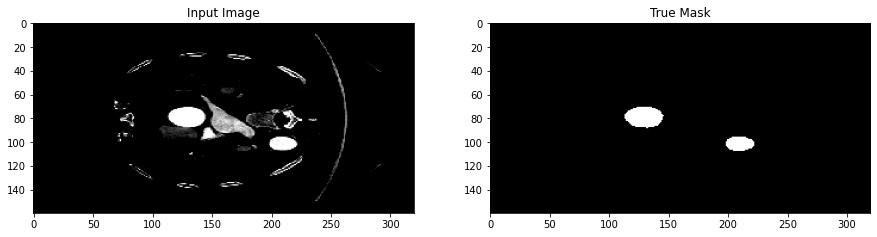

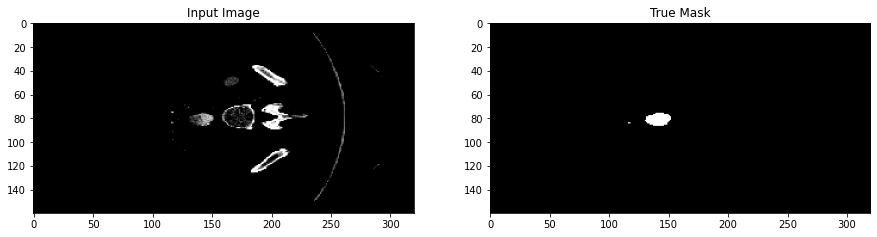

In [ ]:
show_dataset(train_generator, 2)

# **Metricas para evaluar el algoritmo de segmentacion**

*   **Intersection over Union:**
Es un estadistico utilizado para encontrar la similitud y diversidad entre muestras. Se define como, el tamaño de la interseccion dividido entre el tamaño de la union. 



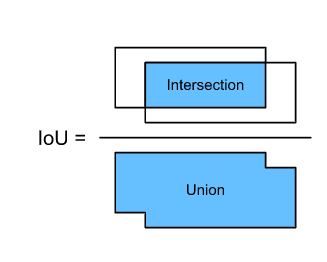

In [ ]:
def iou(y_true, y_pred, smooth = 1):
    intersection = K.sum(K.abs(y_true * y_pred), axis=-1)
    sum_ = K.sum(K.square(y_true), axis = -1) + K.sum(K.square(y_pred), axis=-1)
    jac = (intersection + smooth) / (sum_ - intersection + smooth)
    return jac

*   **Coeficiente Dice:** Es un estadistico utilizado para comparar similitud de 2 muestras.

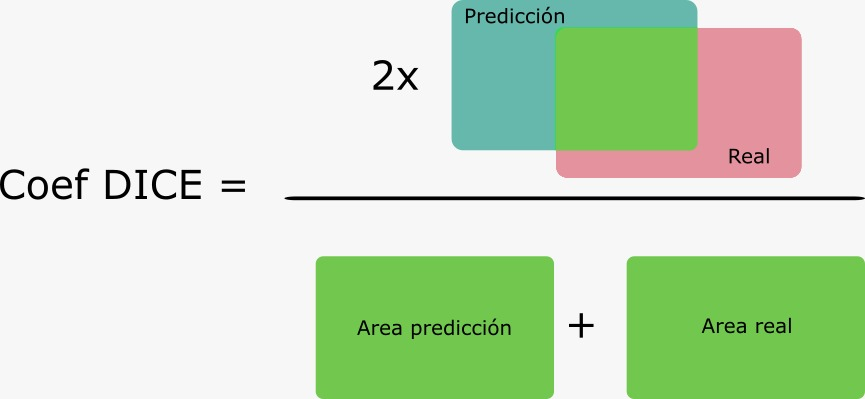

In [ ]:
def dice_coef(y_true, y_pred, smooth=1):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)

*   **Accuracy:** Calcula la tasa de precisión media en todas las predicciones para binarios en problemas de clasificación 



In [ ]:
def accuracy(y_true, y_pred):
    return K.mean(K.equal(y_true, K.round(y_pred)))

# **Implementacion de distintas arquitecturas de redes neuronales**

* **UNET**



In [ ]:
def unet(n_levels, initial_features=32, n_blocks=2, kernel_size=3, pooling_size=2, in_channels=1, out_channels=1):
    inputs = keras.layers.Input(shape=(IMAGE_HEIGHT, IMAGE_WIDTH, in_channels))
    x = inputs
    
    convpars = dict(kernel_size=kernel_size, activation='relu', padding='same')
    
    #downstream
    skips = {}
    for level in range(n_levels):
        for _ in range(n_blocks):
            x = keras.layers.Conv2D(initial_features * 2 ** level, **convpars)(x)
        if level < n_levels - 1:
            skips[level] = x
            x = keras.layers.MaxPool2D(pooling_size)(x)
            
    # upstream
    for level in reversed(range(n_levels-1)):
        x = keras.layers.Conv2DTranspose(initial_features * 2 ** level, strides=pooling_size, **convpars)(x)
        x = keras.layers.Concatenate()([x, skips[level]])
        for _ in range(n_blocks):
            x = keras.layers.Conv2D(initial_features * 2 ** level, **convpars)(x)
            
    # output
    activation = 'sigmoid' if out_channels == 1 else 'softmax'
    x = keras.layers.Conv2D(out_channels, kernel_size=1, activation=activation, padding='same')(x)
    
    return keras.Model(inputs=[inputs], outputs=[x], name=f'UNET-L{n_levels}-F{initial_features}')
        

In [ ]:
EPOCH_STEP_TRAIN = NUM_TRAIN // BATCH_SIZE_TRAIN
EPOCH_STEP_TEST = NUM_TEST // BATCH_SIZE_TEST

In [ ]:
model = unet(4)
opt=keras.optimizers.RMSprop(learning_rate=0.001)
model.compile(optimizer=opt, loss='binary_crossentropy', metrics=[tf.keras.metrics.MeanIoU(num_classes=2), dice_coef, accuracy])

In [ ]:
model.summary()

Model: "UNET-L4-F32"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_9 (InputLayer)            [(None, 160, 320, 1) 0                                            
__________________________________________________________________________________________________
conv2d_30 (Conv2D)              (None, 160, 320, 32) 320         input_9[0][0]                    
__________________________________________________________________________________________________
conv2d_31 (Conv2D)              (None, 160, 320, 32) 9248        conv2d_30[0][0]                  
__________________________________________________________________________________________________
max_pooling2d_36 (MaxPooling2D) (None, 80, 160, 32)  0           conv2d_31[0][0]                  
________________________________________________________________________________________

In [ ]:
history = model.fit_generator(generator=train_generator, 
                    steps_per_epoch=EPOCH_STEP_TRAIN, 
                    validation_data=test_generator, 
                    validation_steps=EPOCH_STEP_TEST,
                   epochs=30)

Epoch 1/30
17/17 [==============================] - 8s 498ms/step - loss: 0.7485 - mean_io_u_6: 0.4973 - dice_coef: 0.0018 - accuracy: 0.9923 - val_loss: 0.0327 - val_mean_io_u_6: 0.4985 - val_dice_coef: 2.2143e-04 - val_accuracy: 0.9970
Epoch 2/30
17/17 [==============================] - 8s 490ms/step - loss: 0.0370 - mean_io_u_6: 0.4974 - dice_coef: 0.0482 - accuracy: 0.9949 - val_loss: 0.0156 - val_mean_io_u_6: 0.4985 - val_dice_coef: 0.0654 - val_accuracy: 0.9970
Epoch 3/30
17/17 [==============================] - 9s 517ms/step - loss: 0.0209 - mean_io_u_6: 0.4974 - dice_coef: 0.1528 - accuracy: 0.9948 - val_loss: 0.0379 - val_mean_io_u_6: 0.4985 - val_dice_coef: 0.0666 - val_accuracy: 0.9971
Epoch 4/30
17/17 [==============================] - 9s 506ms/step - loss: 0.0211 - mean_io_u_6: 0.4973 - dice_coef: 0.1907 - accuracy: 0.9947 - val_loss: 0.0124 - val_mean_io_u_6: 0.4985 - val_dice_coef: 0.1400 - val_accuracy: 0.9970
Epoch 5/30
17/17 [==============================] - 8s 499ms

In [ ]:
model.save(f'UNET-ImplementationRMSprop_30_{IMAGE_HEIGHT}_{IMAGE_WIDTH}.h5')

In [ ]:
model.load_weights('UNET-ImplementationRMSprop_30_160_320.h5')

In [ ]:
test_generator = create_segmentation_generator_test(data_dir_test_image, data_dir_test_mask, 1)

Found 171 images belonging to 1 classes.
Found 171 images belonging to 1 classes.


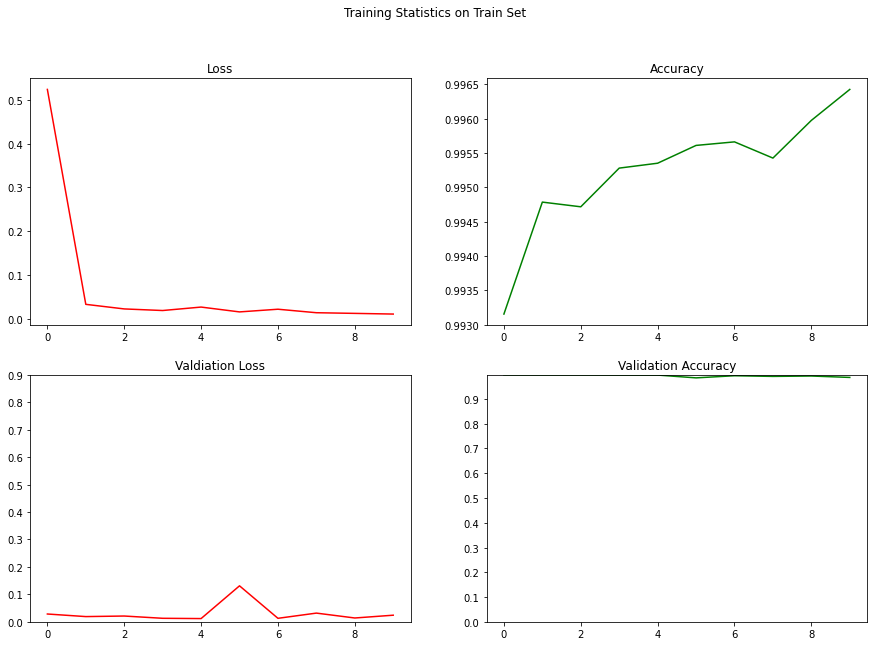

In [ ]:
plt.figure(figsize=(15, 10))
plt.suptitle('Training Statistics on Train Set')
plt.subplot(2,2,1)
plt.plot(history.history['loss'], 'red')
plt.title('Loss')
plt.subplot(2,2,2)
plt.plot(history.history['accuracy'], 'green')
plt.title('Accuracy')
plt.subplot(2,2,3)
plt.plot(history.history['val_loss'], 'red')
plt.yticks(list(np.arange(0.0, 1.0, 0.10)))
plt.title('Valdiation Loss')
plt.subplot(2,2,4)
plt.plot(history.history['val_accuracy'], 'green')
plt.yticks(list(np.arange(0.0, 1.0, 0.10)))
plt.title('Validation Accuracy')
plt.show()

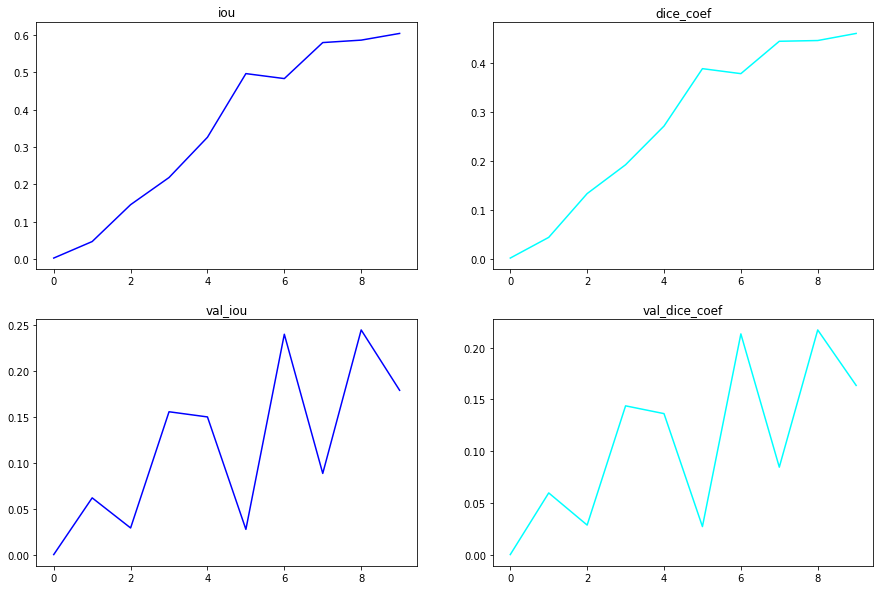

In [ ]:
plt.figure(figsize=(15, 10))
plt.subplot(2,2,1)
plt.plot(history.history['iou'], 'blue')
plt.title('iou')
plt.subplot(2,2,3)
plt.plot(history.history['val_iou'], 'blue')
plt.title('val_iou')
plt.subplot(2,2,2)
plt.plot(history.history['dice_coef'], 'cyan')
plt.title('dice_coef')
plt.subplot(2,2,4)
plt.plot(history.history['val_dice_coef'], 'cyan')
plt.title('val_dice_coef')
plt.show()

In [ ]:
image,mask = next(test_generator)      #print(model.predict(image)[0])
pred_mask = model.predict(image)[0]

In [ ]:
pred_mask

array([[[5.68644926e-02],
        [6.42232504e-03],
        [2.97426456e-03],
        ...,
        [8.15453194e-03],
        [2.63218693e-02],
        [8.03159848e-02]],

       [[1.35809425e-02],
        [6.92518544e-04],
        [1.71943131e-04],
        ...,
        [7.92117789e-04],
        [4.25549829e-03],
        [1.79560147e-02]],

       [[1.47542660e-03],
        [6.98005751e-05],
        [5.93092727e-06],
        ...,
        [6.49524372e-05],
        [6.59597630e-04],
        [4.46418393e-03]],

       ...,

       [[3.63705470e-03],
        [2.89265648e-04],
        [3.43778811e-05],
        ...,
        [3.06456583e-04],
        [2.05888180e-03],
        [9.16339457e-03]],

       [[8.05472303e-03],
        [2.21319683e-03],
        [2.12994739e-04],
        ...,
        [1.86987931e-03],
        [7.93358684e-03],
        [2.07905415e-02]],

       [[5.37202507e-02],
        [1.31991012e-02],
        [3.22113675e-03],
        ...,
        [8.81972536e-03],
        [2.5053

In [ ]:
def show_prediction(datagen, num=1):
    for i in range(0,num):
        image,mask = next(datagen)
        #print(model.predict(image)[0])
        pred_mask = model.predict(image)[0] >0.7
        display([image[0], mask[0], pred_mask])

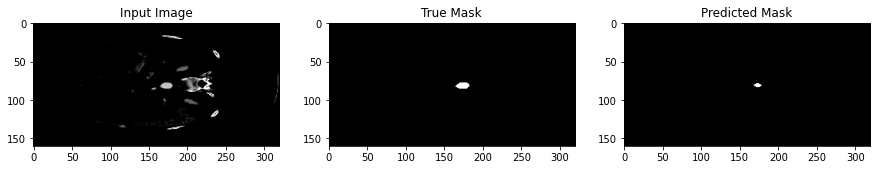

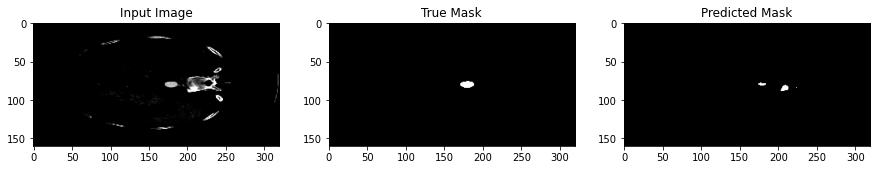

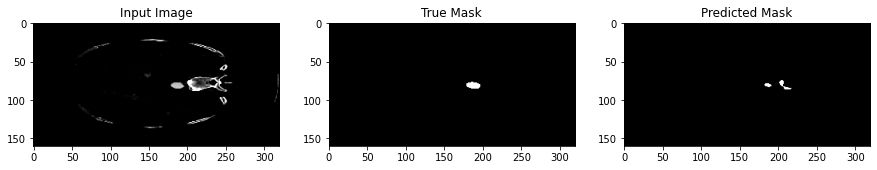

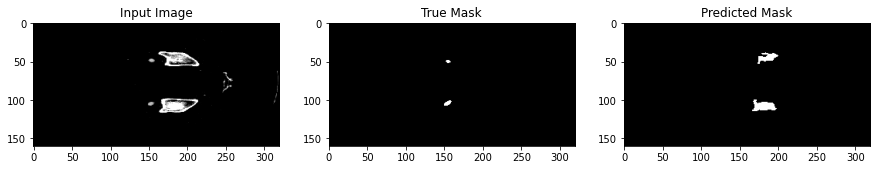

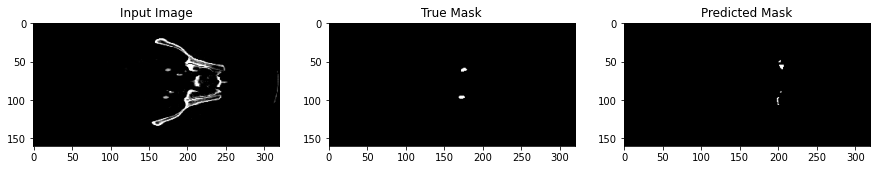

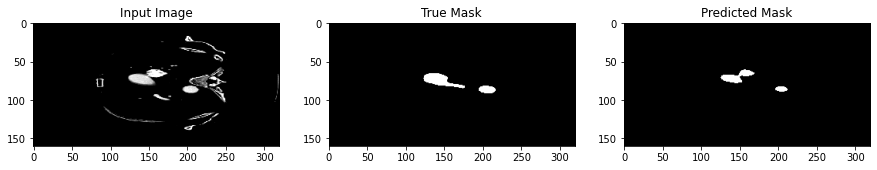

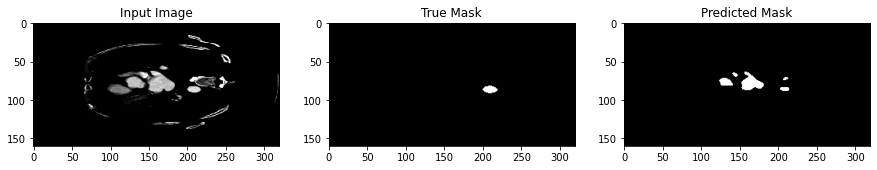

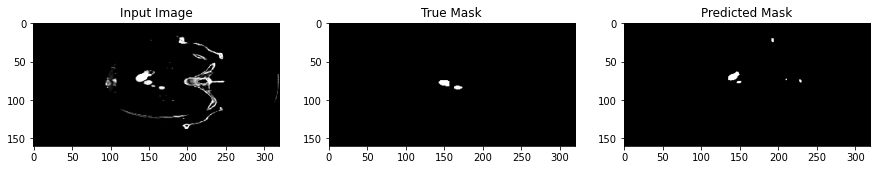

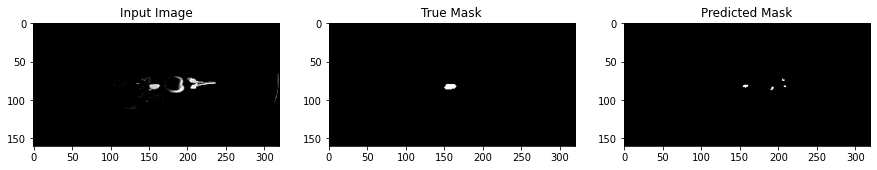

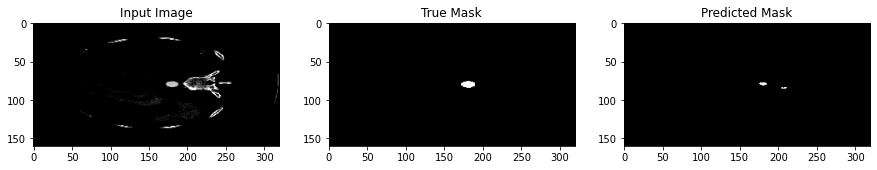

In [ ]:
show_prediction(test_generator, 10)

* **SEGNET**

In [ ]:
def segnet(epochs_num,savename):

    # Encoding layer
    img_input = Input(shape= (160, 320, 1))
    x = Conv2D(64, (3, 3), padding='same', name='conv1',strides= (1,1))(img_input)
    x = BatchNormalization(name='bn1')(x)
    x = Activation('relu')(x)
    x = Conv2D(64, (3, 3), padding='same', name='conv2')(x)
    x = BatchNormalization(name='bn2')(x)
    x = Activation('relu')(x)
    x = MaxPooling2D()(x)
    
    x = Conv2D(128, (3, 3), padding='same', name='conv3')(x)
    x = BatchNormalization(name='bn3')(x)
    x = Activation('relu')(x)
    x = Conv2D(128, (3, 3), padding='same', name='conv4')(x)
    x = BatchNormalization(name='bn4')(x)
    x = Activation('relu')(x)
    x = MaxPooling2D()(x)

    x = Conv2D(256, (3, 3), padding='same', name='conv5')(x)
    x = BatchNormalization(name='bn5')(x)
    x = Activation('relu')(x)
    x = Conv2D(256, (3, 3), padding='same', name='conv6')(x)
    x = BatchNormalization(name='bn6')(x)
    x = Activation('relu')(x)
    x = Conv2D(256, (3, 3), padding='same', name='conv7')(x)
    x = BatchNormalization(name='bn7')(x)
    x = Activation('relu')(x)
    x = MaxPooling2D()(x)

    x = Conv2D(512, (3, 3), padding='same', name='conv8')(x)
    x = BatchNormalization(name='bn8')(x)
    x = Activation('relu')(x)
    x = Conv2D(512, (3, 3), padding='same', name='conv9')(x)
    x = BatchNormalization(name='bn9')(x)
    x = Activation('relu')(x)
    x = Conv2D(512, (3, 3), padding='same', name='conv10')(x)
    x = BatchNormalization(name='bn10')(x)
    x = Activation('relu')(x)
    x = MaxPooling2D()(x)
    
    x = Conv2D(512, (3, 3), padding='same', name='conv11')(x)
    x = BatchNormalization(name='bn11')(x)
    x = Activation('relu')(x)
    x = Conv2D(512, (3, 3), padding='same', name='conv12')(x)
    x = BatchNormalization(name='bn12')(x)
    x = Activation('relu')(x)
    x = Conv2D(512, (3, 3), padding='same', name='conv13')(x)
    x = BatchNormalization(name='bn13')(x)
    x = Activation('relu')(x)
    x = MaxPooling2D()(x)

    x = Dense(1024, activation = 'relu', name='fc1')(x)
    x = Dense(1024, activation = 'relu', name='fc2')(x)
    # Decoding Layer 
    x = UpSampling2D()(x)
    x = Conv2DTranspose(512, (3, 3), padding='same', name='deconv1')(x)
    x = BatchNormalization(name='bn14')(x)
    x = Activation('relu')(x)
    x = Conv2DTranspose(512, (3, 3), padding='same', name='deconv2')(x)
    x = BatchNormalization(name='bn15')(x)
    x = Activation('relu')(x)
    x = Conv2DTranspose(512, (3, 3), padding='same', name='deconv3')(x)
    x = BatchNormalization(name='bn16')(x)
    x = Activation('relu')(x)
    
    x = UpSampling2D()(x)
    x = Conv2DTranspose(512, (3, 3), padding='same', name='deconv4')(x)
    x = BatchNormalization(name='bn17')(x)
    x = Activation('relu')(x)
    x = Conv2DTranspose(512, (3, 3), padding='same', name='deconv5')(x)
    x = BatchNormalization(name='bn18')(x)
    x = Activation('relu')(x)
    x = Conv2DTranspose(256, (3, 3), padding='same', name='deconv6')(x)
    x = BatchNormalization(name='bn19')(x)
    x = Activation('relu')(x)

    x = UpSampling2D()(x)
    x = Conv2DTranspose(256, (3, 3), padding='same', name='deconv7')(x)
    x = BatchNormalization(name='bn20')(x)
    x = Activation('relu')(x)
    x = Conv2DTranspose(256, (3, 3), padding='same', name='deconv8')(x)
    x = BatchNormalization(name='bn21')(x)
    x = Activation('relu')(x)
    x = Conv2DTranspose(128, (3, 3), padding='same', name='deconv9')(x)
    x = BatchNormalization(name='bn22')(x)
    x = Activation('relu')(x)

    x = UpSampling2D()(x)
    x = Conv2DTranspose(128, (3, 3), padding='same', name='deconv10')(x)
    x = BatchNormalization(name='bn23')(x)
    x = Activation('relu')(x)
    x = Conv2DTranspose(64, (3, 3), padding='same', name='deconv11')(x)
    x = BatchNormalization(name='bn24')(x)
    x = Activation('relu')(x)
    
    x = UpSampling2D()(x)
    x = Conv2DTranspose(64, (3, 3), padding='same', name='deconv12')(x)
    x = BatchNormalization(name='bn25')(x)
    x = Activation('relu')(x)
    x = Conv2DTranspose(1, (3, 3), padding='same', name='deconv13')(x)
    x = BatchNormalization(name='bn26')(x)
    pred = Activation('sigmoid')(x)
    
    model = Model(inputs=img_input, outputs=pred)
    
    model.compile(optimizer= tf.keras.optimizers.RMSprop(lr=0.001), loss= ["binary_crossentropy"]
                  , metrics=[tf.keras.metrics.MeanIoU(num_classes=2), dice_coef, accuracy])
    model.summary()
    hist = model.fit_generator(generator=train_generator, 
                    steps_per_epoch=EPOCH_STEP_TRAIN, 
                    validation_data=test_generator, 
                    validation_steps=EPOCH_STEP_TEST,
                   epochs=20)
    
    model.save(savename)
    return model,hist

In [ ]:
model, hist = segnet(10, 'segnet_30_epoch.h5')

Model: "functional_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_8 (InputLayer)         [(None, 160, 320, 1)]     0         
_________________________________________________________________
conv1 (Conv2D)               (None, 160, 320, 64)      640       
_________________________________________________________________
bn1 (BatchNormalization)     (None, 160, 320, 64)      256       
_________________________________________________________________
activation_130 (Activation)  (None, 160, 320, 64)      0         
_________________________________________________________________
conv2 (Conv2D)               (None, 160, 320, 64)      36928     
_________________________________________________________________
bn2 (BatchNormalization)     (None, 160, 320, 64)      256       
_________________________________________________________________
activation_131 (Activation)  (None, 160, 320, 64)    

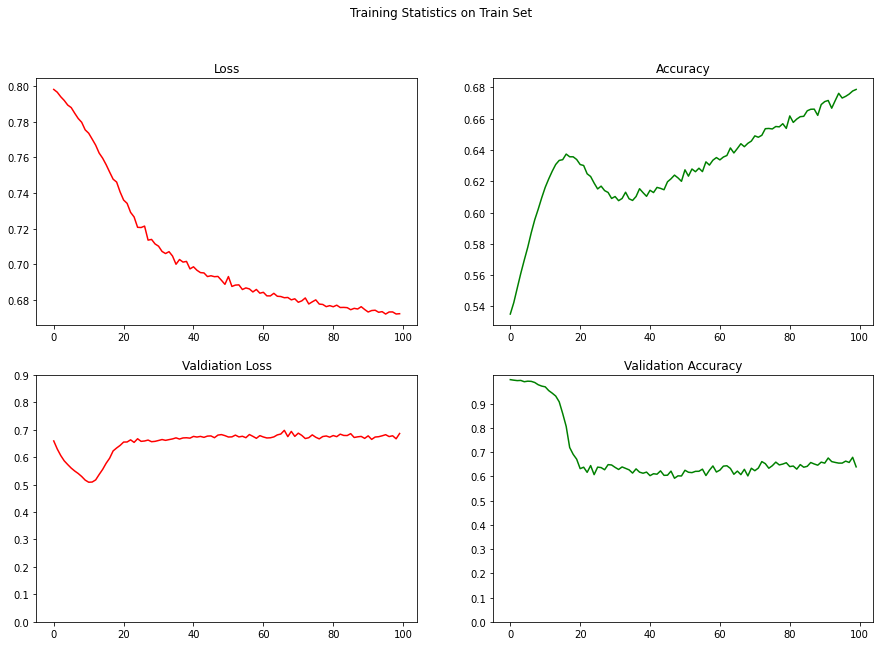

In [ ]:
plt.figure(figsize=(15, 10))
plt.suptitle('Training Statistics on Train Set')
plt.subplot(2,2,1)
plt.plot(hist.history['loss'], 'red')
plt.title('Loss')
plt.subplot(2,2,2)
plt.plot(hist.history['accuracy'], 'green')
plt.title('Accuracy')
plt.subplot(2,2,3)
plt.plot(hist.history['val_loss'], 'red')
plt.yticks(list(np.arange(0.0, 1.0, 0.10)))
plt.title('Valdiation Loss')
plt.subplot(2,2,4)
plt.plot(hist.history['val_accuracy'], 'green')
plt.yticks(list(np.arange(0.0, 1.0, 0.10)))
plt.title('Validation Accuracy')
plt.show()

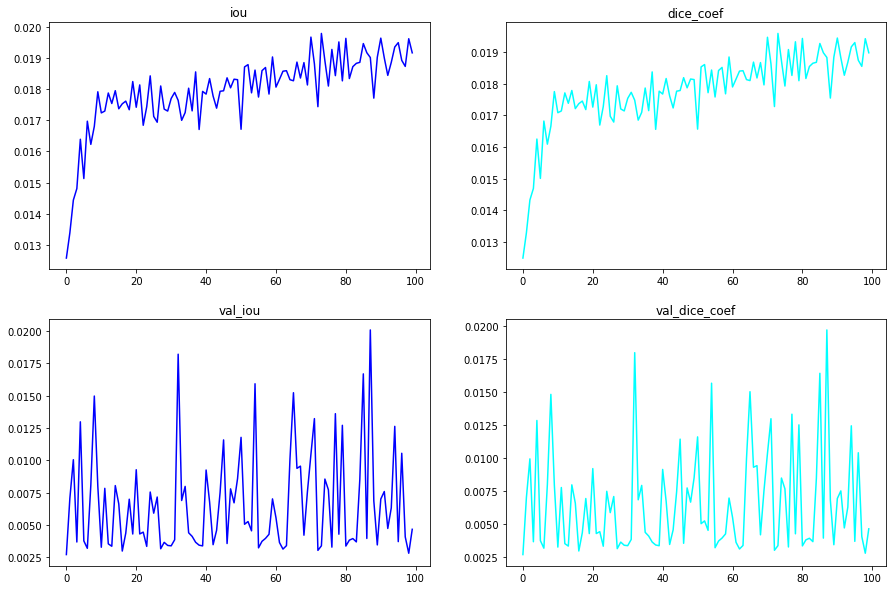

In [ ]:
plt.figure(figsize=(15, 10))
plt.subplot(2,2,1)
plt.plot(hist.history['iou'], 'blue')
plt.title('iou')
plt.subplot(2,2,3)
plt.plot(hist.history['val_iou'], 'blue')
plt.title('val_iou')
plt.subplot(2,2,2)
plt.plot(hist.history['dice_coef'], 'cyan')
plt.title('dice_coef')
plt.subplot(2,2,4)
plt.plot(hist.history['val_dice_coef'], 'cyan')
plt.title('val_dice_coef')
plt.show()

In [ ]:
def show_prediction(datagen, num=1):
    for i in range(0,num):
        image,mask = next(datagen)
        #print(model.predict(image)[0])
        pred_mask = model.predict(image)[0]>0.86
        display([image[0], mask[0], pred_mask])
        print(mask.shape)

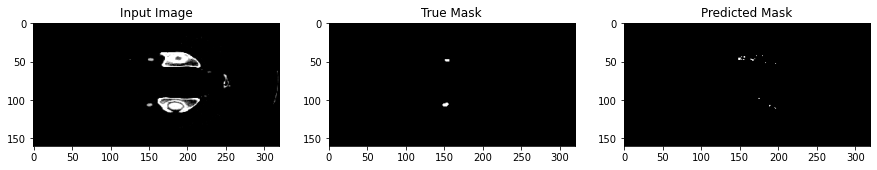

(1, 160, 320, 1)


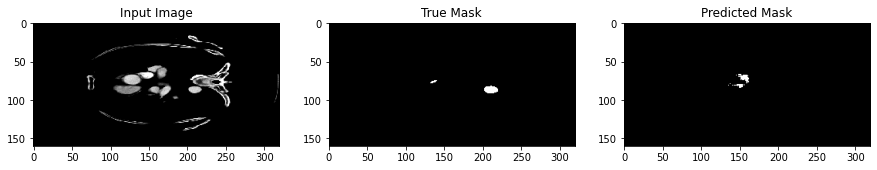

(1, 160, 320, 1)


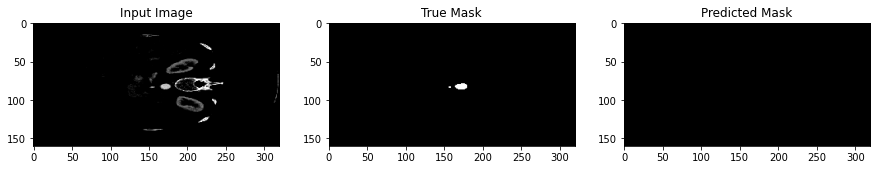

(1, 160, 320, 1)


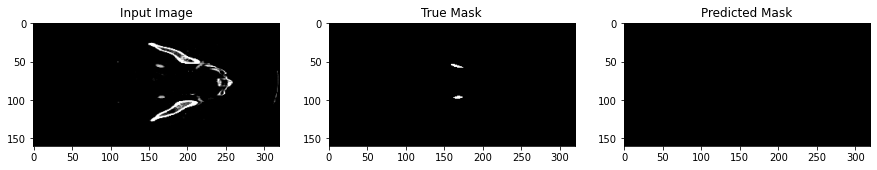

(1, 160, 320, 1)


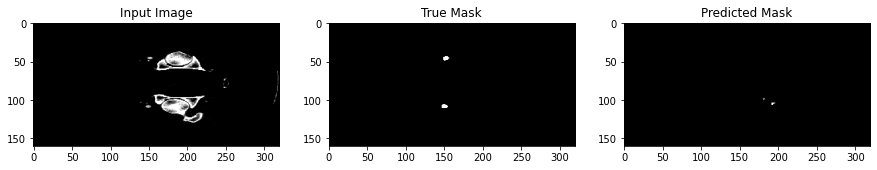

(1, 160, 320, 1)


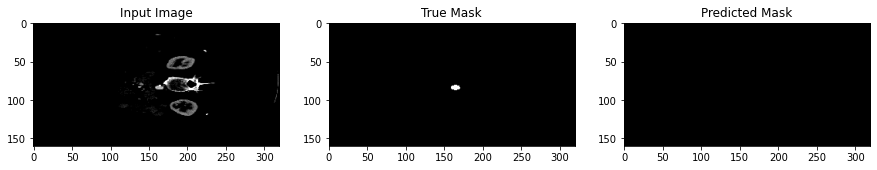

(1, 160, 320, 1)


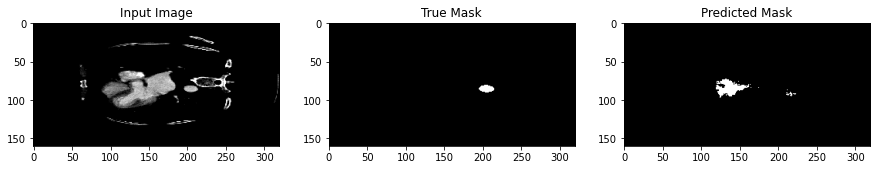

(1, 160, 320, 1)


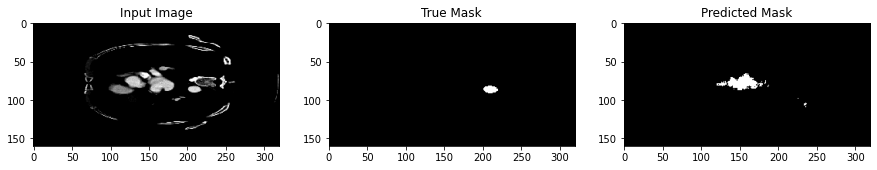

(1, 160, 320, 1)


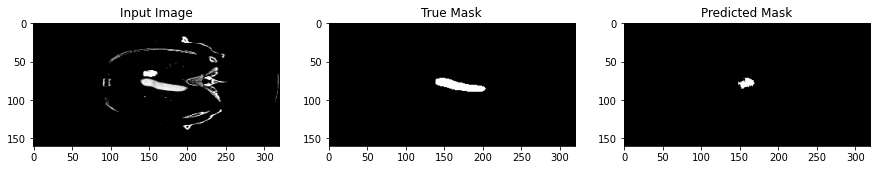

(1, 160, 320, 1)


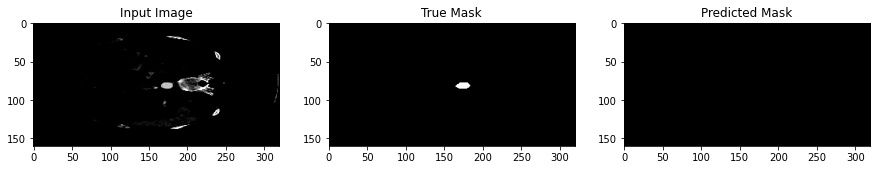

(1, 160, 320, 1)


In [ ]:
show_prediction(test_generator, 10)

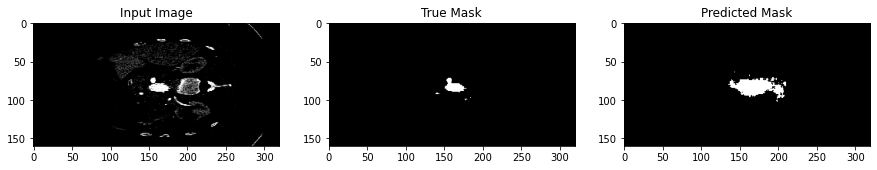

(32, 160, 320, 1)


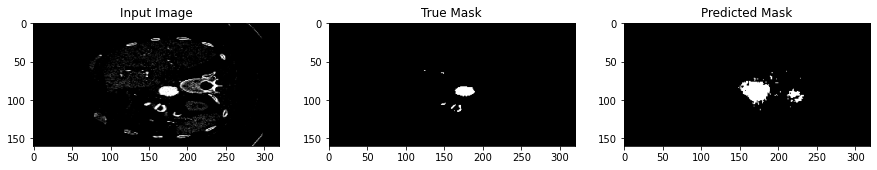

(32, 160, 320, 1)


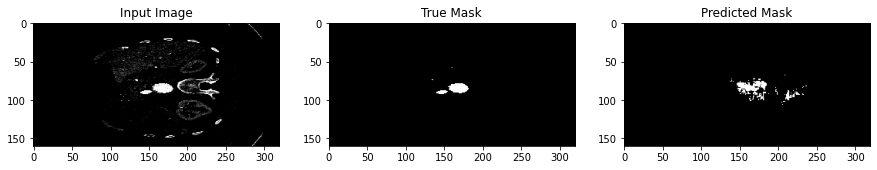

(32, 160, 320, 1)


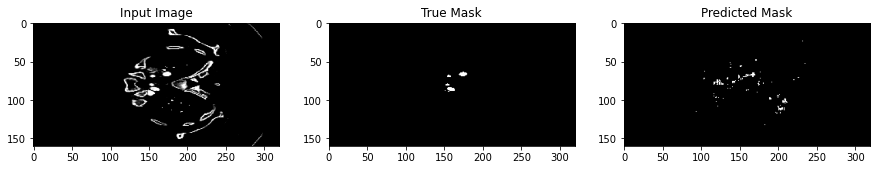

(32, 160, 320, 1)


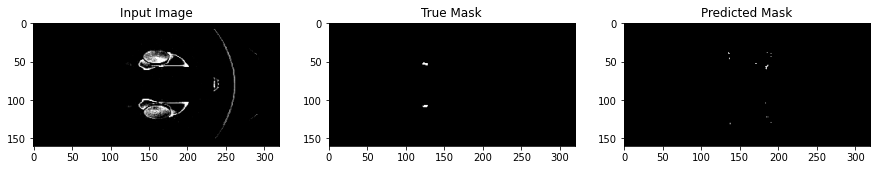

(32, 160, 320, 1)


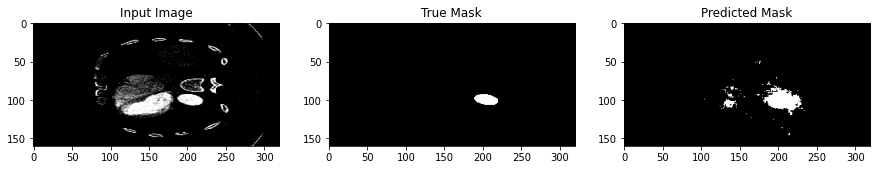

(32, 160, 320, 1)


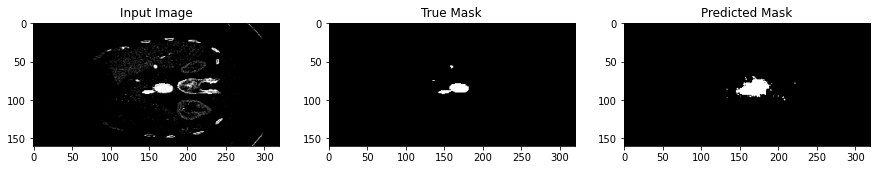

(32, 160, 320, 1)


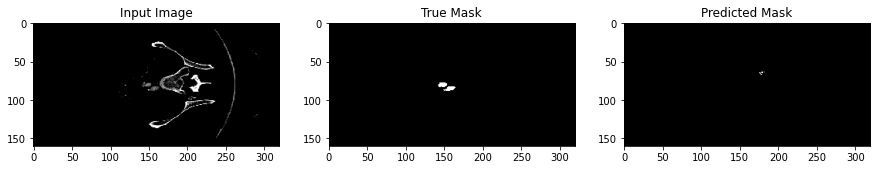

(32, 160, 320, 1)


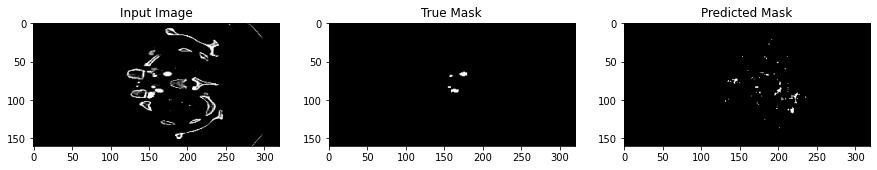

(32, 160, 320, 1)


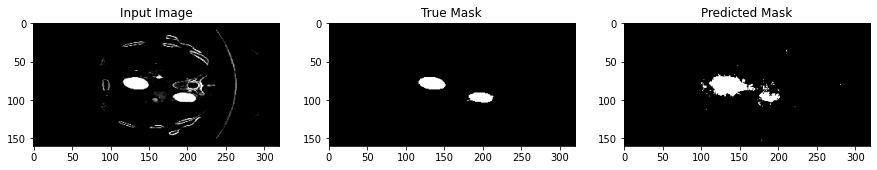

(32, 160, 320, 1)


In [ ]:
show_prediction(test_generator, 10)

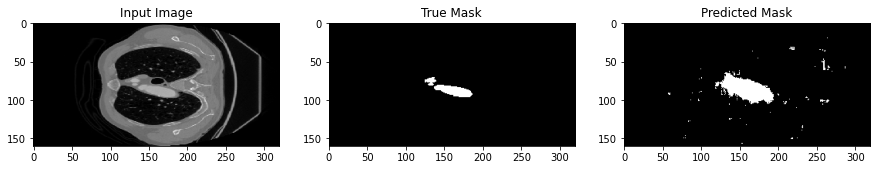

(32, 160, 320, 1)


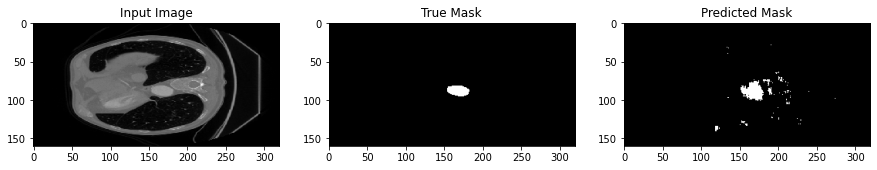

(32, 160, 320, 1)


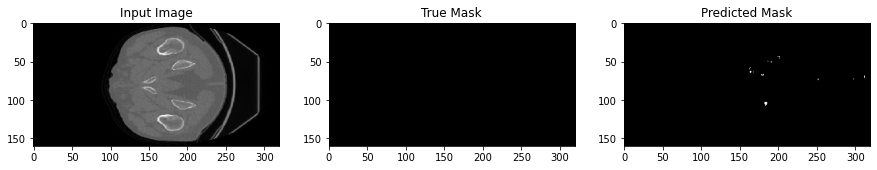

(32, 160, 320, 1)


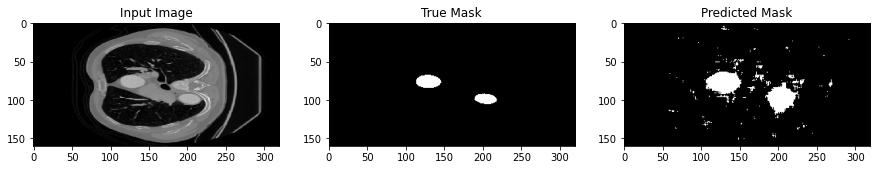

(32, 160, 320, 1)


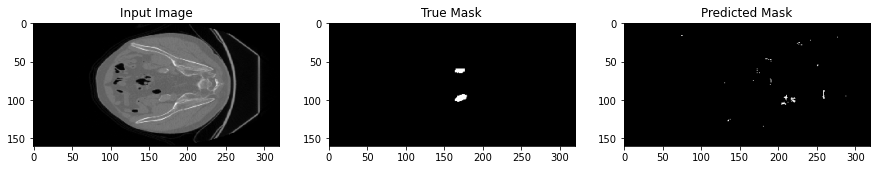

(32, 160, 320, 1)


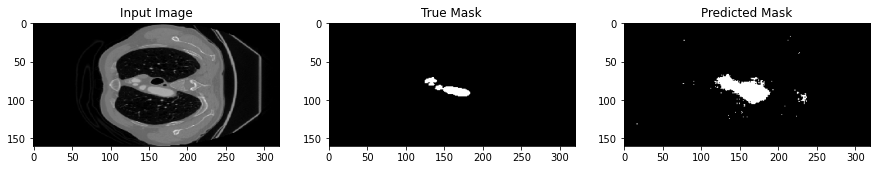

(32, 160, 320, 1)


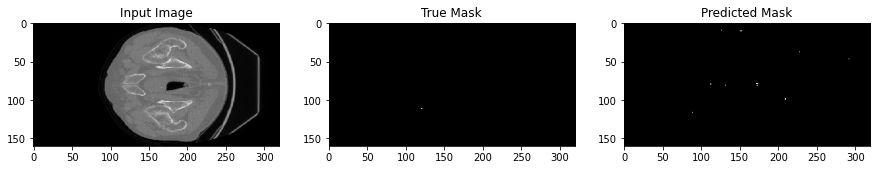

(32, 160, 320, 1)


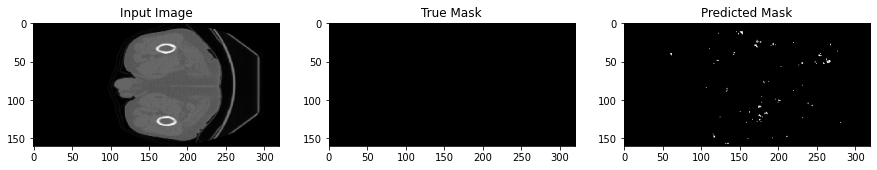

(32, 160, 320, 1)


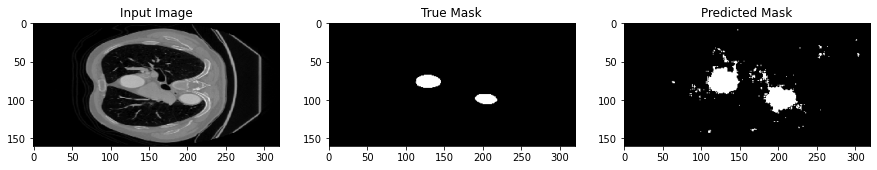

(32, 160, 320, 1)


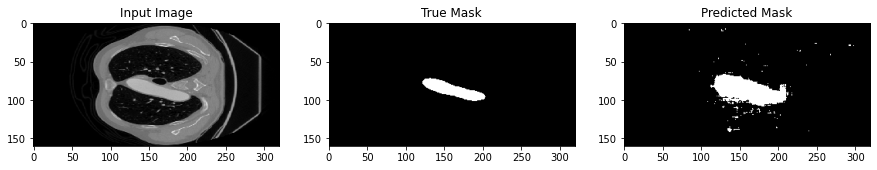

(32, 160, 320, 1)


In [ ]:
show_prediction(test_generator, 10)